# Import module

In [4]:
# !pip install transformers --quiet

In [5]:
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import os

from transformers import GPT2Tokenizer

# Tạo các hàm tiền xử lý

In [6]:
# Đọc dữ liệu
ROOT_PATH = './'
filename = 'data.txt'
with open(os.path.join(ROOT_PATH, filename), 'r', encoding='utf-8') as f:
    data = f.read()

In [7]:
# giới hạn data để train nhanh hơn
data_limited = data[:300000]

In [9]:
# Tiền xử lý văn bản
def process_vi(data):
    parts = re.split(r'=+.+=+', data)
    res = []
    for part in parts:
        if len(part.split()) > 20: # số lượng từ trong 1 thành phần lớn hơn 20 chữ
            p = part.strip()
            # p = part.lower()
            # p = re.sub(r'[!“”"#$%&\()*+,-./:;<=>?@[\]^_`{|}~]', " ", p)
            # p = re.sub(r'\s+', ' ', p)
            res.append('<s>'+ p +'</s>') # do GPT tokenizer khi encode không có bos và eos token nên mình phải thêm vào
    return res

In [10]:
data_preprocess = process_vi(data_limited)

In [11]:
len(data_preprocess)

165

In [12]:
MAX_LENGTH = 64

# Transformer with Decoder

### Tiền xử lý dữ liệu

In [ ]:
# Khởi tạo tokenizer và thêm các ký tự bắt đầu, kết thúc và padding câu
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')
tokenizer.add_special_tokens({"pad_token": "<pad>", 
                                "bos_token": "<s>",
                                "eos_token": "</s>"})
print('Vocab size: ', tokenizer.vocab_size)

In [14]:
# tokenize các chữ thành số
data_ids = tokenizer(data_preprocess, return_attention_mask=False, return_token_type_ids=False).input_ids

In [15]:
# padding của tokenizer
tokenizer.encode('<pad>')

[1]

In [16]:
# các chuỗi số có kích thước không bằng nhau nên ở đây mình xử lý 2 bước
# 1 là với câu nhỏ hơn maxlength thì mình sẽ padding ra
# 2 là với các câu lớn hơn maxlength thì mình sẽ cắt ra thành nhiều seq rồi padding seq cuối
def create_sequences_and_padding(sequence, max_length=MAX_LENGTH, window_size=16):
    if len(sequence) < MAX_LENGTH:
        return [sequence + [1]*(MAX_LENGTH-len(sequence))] # 1 là padding của tokenizer (một số tokenizer khác là 0 hoặc số khác)
    seqs = []
    for i in range(0, len(sequence)-max_length, window_size):
        seqs.append(sequence[i:i+max_length])
        if i+window_size > len(sequence)-max_length:
            i += window_size
            seq = sequence[i:i+max_length]
            seqs.append(seq + [1]*(max_length-len(seq)))
    return seqs # list tokens


In [17]:
sequences = []
for paragraph in data_ids:
    sequences += create_sequences_and_padding(paragraph)
sequences = tf.convert_to_tensor(sequences)
sequences.shape

TensorShape([4281, 64])

# Model

In [71]:
# Các hàm quan trọng
# positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # sử dụng sin cho vị trí số chẵn trong mảng, 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # sử dụng cos cho vị trí số lẻ trong mảng, 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [72]:
# TokenEmbedding
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                        input_vocab_size, # tokenizer.vocab_size
                        max_length): # max_seq_length - MAX_LENGTH
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_length, d_model)

    def call(self, x): # x(batch_size, input_seq_len)
        seq_len = tf.shape(x)[1]
        # cộng token embedding và position encoding.
        x = self.embedding(x)  # x(batch_size, input_seq_len, d_model), Input Embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        pos_enc = self.pos_encoding[:, :seq_len, :] # Positional Encoding   
        
        return x + pos_enc

In [73]:
# Decoder 
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, # embedding_dimension
                    num_heads6, 
                    dff, # feed_forward_dimension
                    rate):
        super().__init__()
        
        # Khởi tạo multihead Attention
        self.att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        
        # Linear FNN
        self.ffn = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(dff, activation="relu"),
                    tf.keras.layers.Dense(d_model),
                ]
            )
        
        # Add Norm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        # nếu ta sử dụng Multi-head attention trên cả câu như ở Encoder, 
        # Decoder sẽ nhận luôn từ tiếp theo mà nó cần dịch. Để ngăn điều đó, 
        # khi Decoder dịch đến từ thứ i, phần sau của câu sẽ bị che lại (masked) 
        # và Decoder chỉ được phép nhận thấy phần nó đã dịch trước đó.
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        # trả về mảng mới với các chiều dữ liệu mới dựa theo mult
        return tf.tile(mask, mult)

    def call(self, x, training=False):
        shape = tf.shape(x)
        batch_size = shape[0]
        seq_len = shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        # sub layer 1
        attn1 = self.att(x, x, attention_mask=causal_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Residual -> Norm

        # sub layer 2
        ffn_output = self.ffn(out1)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(ffn_output + out1)   # Residual -> Norm
        # output decode out2
        return out2 # (batch_size, target_seq_len, d_model)

In [123]:
class LanguageModel(tf.keras.Model):
    def __init__(self,
            input_vocab_size,  # input_vocab_size - Số lượng token có trong tokenizer (vocab size) (cũng là num class)
            max_length,        # MAX_LENGTH - maximum sequence length
            d_model,           # dimension token embeddings
            num_layers,        # Số lượng cá lớp decoder chồng lên nhau
            num_heads,         # Số Attention Head
            dff,               # Số chiều của lớp feed forward
            rate               # dropout rate
        ):
        super().__init__()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")

        self.num_layers_dec = num_layers
        self.target_maxlen = max_length
        self.num_classes = input_vocab_size
        
        # Khởi tạo tầng Embedding
        self.dec_input = TokenEmbedding(
            d_model, 
            input_vocab_size, # tokenizer.vocab_size
            max_length
        )
        # Khởi tạo các lớp decoder chồng lên nhau
        for i in range(num_layers):
            setattr(
                self,
                f"dec_layer_{i}",
                DecoderLayer( d_model, # embedding_dimension
                    num_heads, 
                    dff, # feed_forward_dimension
                    rate),
            )
        # Khởi tạo lớp đầu ra
        self.classifier = tf.keras.layers.Dense(self.num_classes)

    def decode(self, x):
        # Dự đoán từng từ trong câu
        x = self.dec_input(x)
        for i in range(self.num_layers_dec):
            x = getattr(self, f"dec_layer_{i}")(x)
        return x

    def call(self, x): # (batch_size, input_seq_len)
        x = self.decode(x)
        return self.classifier(x)

    @property
    def metrics(self):
        return [self.loss_metric]

    # Hàm train model
    def train_step(self, batch): # [CLS] i am a student [SEP]
        dec_input = batch[:, :-1]  # [CLS] i am a student 
        dec_target = batch[:, 1:]  #       i am a student [SEP]
        
        with tf.GradientTape() as tape:
            preds = self(dec_input)
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            # Tính loss dựa trên preds và ont_hot của dec_target
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # áp dụng thuật toán tối ưu và cập nhật 
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, x, generate_length=64):
        # Thực hiện suy luận trên một loạt đầu vào (batch of input) bằng cách sử dụng giải thuật greedy
        # seq_len = tf.shape(x)[1]
        out = []
        for _ in range(generate_length): # self.target_maxlen - seq_len
            dec_out = self.decode(x)
            logits = self.classifier(dec_out)
            # logits là giá trị từ tiếp theo của n từ trước nó
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            out.append(last_logit[0].numpy()[0])
            x = tf.concat([x, last_logit], axis=-1)[:, -self.target_maxlen:] # length x phải nhỏ hơn MAX_lENGTH
        return out


In [124]:
# config
input_vocab_size = tokenizer.vocab_size  # Số lượng token có trong tokenizer (vocab size) (cũng là num class)
d_model = 256 # embedding_dimension (dimension token embeddings)
num_layers = 8
num_heads = 6
dff = d_model*4 # bài báo của GPT-2 sử dụng 4 * embedding_dimension cho số chiều của feed forward
rate = 0.1

# Khởi tạo model
model = LanguageModel(
            input_vocab_size=input_vocab_size,  
            max_length = MAX_LENGTH ,
            d_model = d_model, 
            num_layers = num_layers,  
            num_heads = num_heads,  
            dff = dff, 
            rate = rate 
)

In [143]:
# Khởi tạo hàm lỗi
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)
# Khởi tạo thuật toán tối ưu Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
# Compile và fit model với 200 epochs
model.compile(optimizer=optimizer, loss=loss_fn)
history = model.fit(sequences, batch_size=64, epochs=100) # 2 lần 100 epochs

Epoch 1/100
67/67 [==============================] - 39s 227ms/step - loss: 1.5711
Epoch 2/100
67/67 [==============================] - 15s 226ms/step - loss: 1.5051
Epoch 3/100
67/67 [==============================] - 15s 224ms/step - loss: 1.5024
Epoch 4/100
67/67 [==============================] - 15s 226ms/step - loss: 1.5014
Epoch 5/100
67/67 [==============================] - 15s 223ms/step - loss: 1.5002
Epoch 6/100
67/67 [==============================] - 15s 224ms/step - loss: 1.4996
Epoch 7/100
67/67 [==============================] - 15s 224ms/step - loss: 1.4986
Epoch 8/100
67/67 [==============================] - 15s 225ms/step - loss: 1.4978
Epoch 9/100
67/67 [==============================] - 15s 223ms/step - loss: 1.4971
Epoch 10/100
67/67 [==============================] - 15s 224ms/step - loss: 1.4974
Epoch 11/100
67/67 [==============================] - 15s 225ms/step - loss: 1.5019
Epoch 12/100
67/67 [==============================] - 15s 223ms/step - loss: 1.5158
E

In [152]:
# model.save_weights('./my_checkpoint')

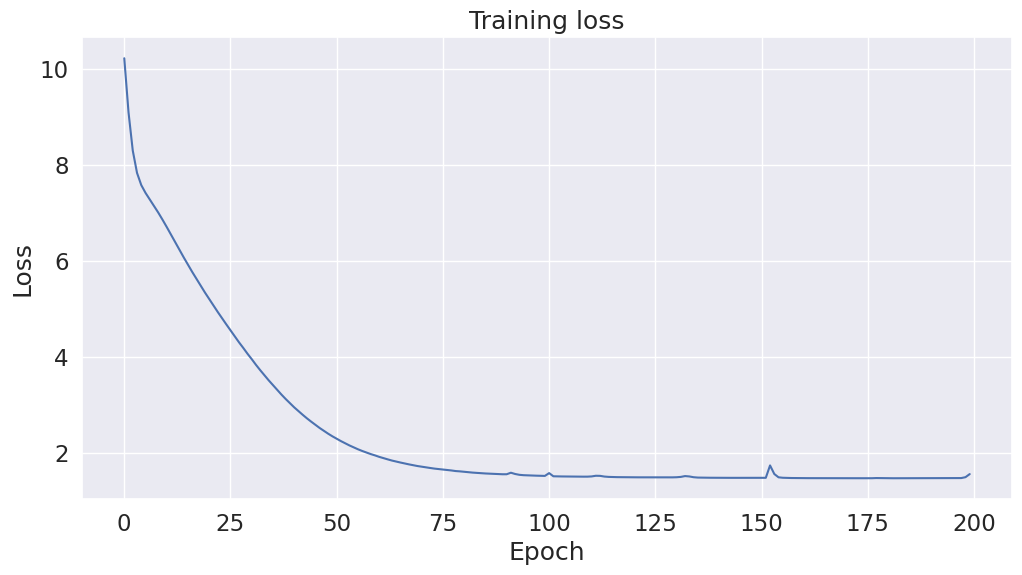

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

values += history.history['loss'] 
# Use plot styling from seaborn.  
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(values , 'b')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [151]:
text_input = '''Tiếng Việt

Tiếng Việt, còn gọi tiếng Việt Nam hay Việt ngữ, là'''
text_input = '<s>'+text_input+'</s>'
input_ids = tf.convert_to_tensor([tokenizer.encode(text_input)])

token_generate = model.generate(input_ids[:,:-1], 50) # bỏ </s>
text_generated = tokenizer.decode(token_generate)

print(text_input)
print()
print(text_generated)

<s>Tiếng Việt

Tiếng Việt, còn gọi tiếng Việt Nam hay Việt ngữ, là</s>

 ngôn ngữ của người Việt và là ngôn ngữ chính thức tại Việt Nam. Đây là tiếng mẹ đẻ của khoảng 85% dân cư Việt Nam, cùng với hơn 4 triệu người Việt hải ngoại. Tiếng Việt còn là ngôn ngữ thứ hai trong tiếng Anh
